##  Training

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.imgs = df.imgs.values
        self.labels = df.labels.values
        self.transform = transform
        
    def __getitem__(self, idx):
        image = np.array(Image.open(self.imgs[idx]).convert('RGB'))
        if self.transform != None:
            image = transform(image)
        label = self.labels[idx]
        return image, label
    
    def __len__(self):
        return len(self.imgs)

In [ ]:
class Net(nn.Module):
    def __init__(self, feature_extractor):
        super().__init__()
        self.feature_extractor = feature_extractor # output size [BS, 512, 1 1]
        self.classifier = nn.Sequential(*[nn.Linear(512, 3),
                                          nn.Softmax(dim=-1)])
        
    def forward(self, x):
        x = self.feature_extractor(x).view(-1, 512)
        x = self.classifier(x)
        return x

In [ ]:
def train(net, dataloader, criterion, optimizer, device):
    net.train()
    running_loss = 0
    for idx, (x, y) in enumerate(dataloader):
        print('\r{:.2f}%'.format((idx+1) / len(dataloader) * 100), end='')
        x = x.to(device)
        y = y.to(device).long()
        
        optimizer.zero_grad()
        
        predict = net(x)
        loss = criterion(predict.squeeze(), y)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    return running_loss / len(dataloader)

In [ ]:
def evaluate(net, dataloader, criterion, device):
    net.eval()
    predicts = []
    labels = []
    
    running_loss = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device).long()

            predict = net(x)
            loss = criterion(predict.squeeze(), y)
            predict = predict.argmax(1)
            predicts.append(predict.cpu().numpy())
            labels.append(y.cpu().numpy())
            
            running_loss += loss.item()
    return np.concatenate(predicts), np.concatenate(labels), running_loss / len(dataloader)

In [ ]:
def epoch_time(start, end):
    diff = end - start
    m = int(diff / 60)
    s = int(diff - m * 60)
    return m, s

In [ ]:
DATA_PATH = './COVID-19 Radiography Database'

N_EPOCHS = 3
BATCH_SIZE = 32

In [ ]:
covid_imgs = [os.path.join(DATA_PATH, 'COVID-19', i) for i in os.listdir(os.path.join(DATA_PATH, 'COVID-19'))]
normal_imgs = [os.path.join(DATA_PATH, 'NORMAL', i) for i in os.listdir(os.path.join(DATA_PATH, 'NORMAL'))]
pneu_imgs = [os.path.join(DATA_PATH, 'Viral Pneumonia', i) for i in os.listdir(os.path.join(DATA_PATH, 'Viral Pneumonia'))]
imgs = covid_imgs + normal_imgs + pneu_imgs

labels = np.r_[np.zeros((len(covid_imgs), )), np.ones((len(normal_imgs), )), np.ones((len(pneu_imgs), )) * 2]

In [ ]:
df = pd.DataFrame({'imgs':imgs, 'labels':labels})
df_train, df_test = train_test_split(df, test_size=0.2)
df_val, df_test = train_test_split(df_test, test_size=0.5)

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = Dataset(df_train, transform)
val_dataset = Dataset(df_val, transform)
test_dataset = Dataset(df_test, transform)

train_iterator = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_iterator = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

resnet = models.resnet18(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])

net = Net(resnet).to(device)

weight = df_train.labels.value_counts().sort_values().values
weight = torch.FloatTensor(weight.max() / weight).to(device)

criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = optim.Adam(net.parameters())

In [ ]:
net.load_state_dict(torch.load('model.pkl'))

In [ ]:
for epoch in range(N_EPOCHS):
    start = time.time()
    train_loss = train(net, train_iterator, criterion, optimizer, device)
    _, _, val_loss = evaluate(net, val_iterator, criterion, device)
    end = time.time(mapping = {0:'Covid',1:'Normal',2:'Viral Pneumonia'}

plt.figure(figsize=(12,12))
for i in range(3):
    plt.subplot(3,3,i+1)
    img = np.array(Image.open(covid_imgs[i]).resize((224,224)))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Covid')
    
for i in range(3,6):
    plt.subplot(3,3,i+1)
    img = np.array(Image.open(normal_imgs[i]).resize((224,224)))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Normal')
    
for i in range(6,9):
    plt.subplot(3,3,i+1)
    img = np.array(Image.open(pneu_imgs[i]).resize((224,224)))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Viral Pneumonia')

count = df_train.labels.value_counts().to_dict()
sns.barplot(x=[mapping[i] for i in count.keys()], y=list(count.values()))
plt.title('Number of data for each class in training dataset')
plt.xlabel('Class')
plt.ylabel('Count')

count = df_val.labels.value_counts().to_dict()
sns.barplot(x=[mapping[i] for i in count.keys()], y=list(count.values()))
plt.title('Number of data for each class in validation dataset')
plt.xlabel('Class')
plt.ylabel('Count')

count = df_test.labels.value_counts().to_dict()
sns.barplot(x=[mapping[i] for i in count.keys()], y=list(count.values()))
plt.title('Number of data for each class in testing dataset')
plt.xlabel('Class')
plt.ylabel('Count')

cm = confusion_matrix(label, pre)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=['Covid','Normal','Viral Pneunomia'], columns=['Covid','Normal','Viral Pneunomia'])

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predict label'))
    
    m, s = epoch_time(start, end)
    
    print(f'Epoch {epoch+1} | Time : {m}m {s}s')
    print(f'Train Loss : {train_loss:.4f}')
    print(f'Val Loss : {val_loss:.4f}')
    print()

In [ ]:
torch.save(net.state_dict(), 'model.pkl')

In [ ]:
pre, label, _ = evaluate(net, test_iterator, device)

In [ ]:
print(classification_report(label, pre))

In [ ]:
print('Accuracy : ', (pre == label).mean())
print('Precision score : ', precision_score(label, pre, average='macro'))
print('Recall score : ', recall_score(label, pre, average='macro'))
print('F1 score : ', f1_score(label, pre, average='macro'))
print('Confusion Matrix : ', confusion_matrix(label, pre))

In [ ]:
def inference(net, image_path, transform, device):
    net.eval()
    image = np.array(Image.open(image_path).convert('RGB'))
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        image = image.to(device)
        predict = net(image)
        predict = predict.argmax(1)
    return predict[0].item()

In [ ]:
inference(net, normal_imgs[0], transform, device)

### Visualization

In [67]:
mapping = {0:'Covid',1:'Normal',2:'Viral Pneumonia'}

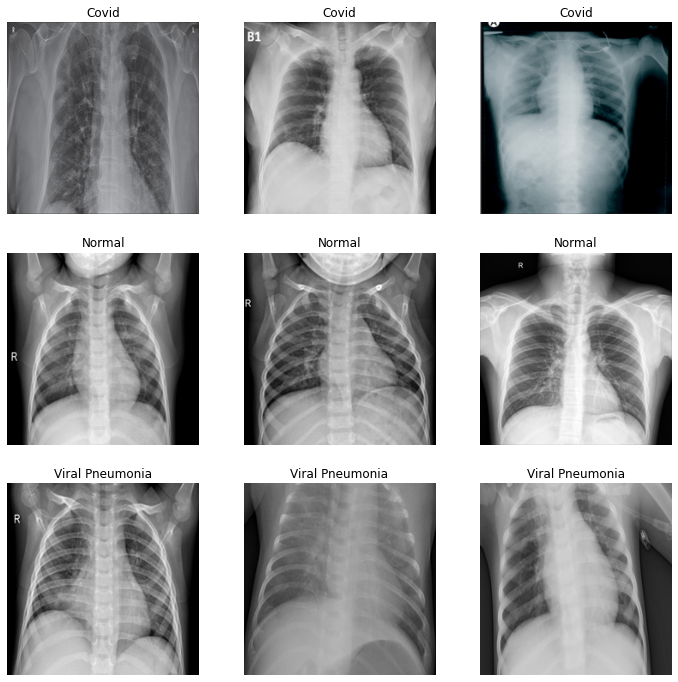

In [113]:
plt.figure(figsize=(12,12))
for i in range(3):
    plt.subplot(3,3,i+1)
    img = np.array(Image.open(covid_imgs[i]).resize((224,224)))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Covid')
    
for i in range(3,6):
    plt.subplot(3,3,i+1)
    img = np.array(Image.open(normal_imgs[i]).resize((224,224)))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Normal')
    
for i in range(6,9):
    plt.subplot(3,3,i+1)
    img = np.array(Image.open(pneu_imgs[i]).resize((224,224)))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Viral Pneumonia')

Text(0, 0.5, 'Count')

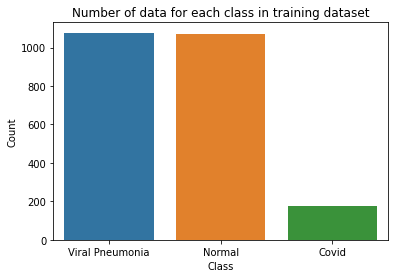

In [140]:
count = df_train.labels.value_counts().to_dict()
sns.barplot(x=[mapping[i] for i in count.keys()], y=list(count.values()))
plt.title('Number of data for each class in training dataset')
plt.xlabel('Class')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

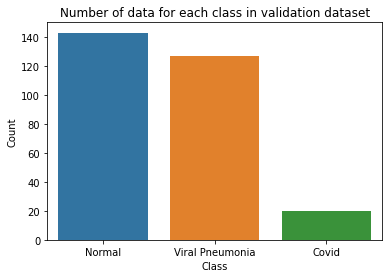

In [141]:
count = df_val.labels.value_counts().to_dict()
sns.barplot(x=[mapping[i] for i in count.keys()], y=list(count.values()))
plt.title('Number of data for each class in validation dataset')
plt.xlabel('Class')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

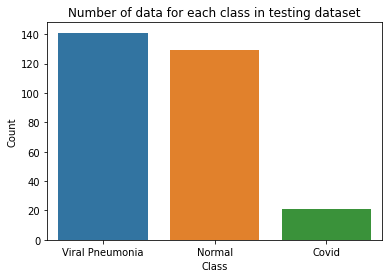

In [142]:
count = df_test.labels.value_counts().to_dict()
sns.barplot(x=[mapping[i] for i in count.keys()], y=list(count.values()))
plt.title('Number of data for each class in testing dataset')
plt.xlabel('Class')
plt.ylabel('Count')

Text(0.5, 42.0, 'Predict label')

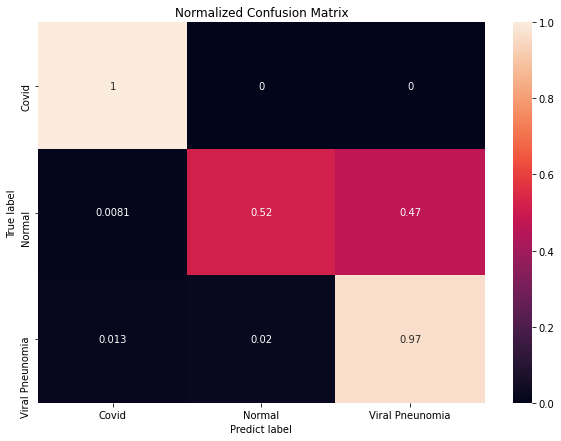

In [48]:
cm = confusion_matrix(label, pre)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=['Covid','Normal','Viral Pneunomia'], columns=['Covid','Normal','Viral Pneunomia'])

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predict label')